# Multi-level strain optimization approaches

Several strain design approaches use MILPs with nested optimization to enforce growth-coupled production. As the first nested optimization algorithm, OptKnock <a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref2'><sup>[2]</sup></a> aimed to resolve the conflict between the microbial objective of fast growth with the engineering goal of fast production. It therefore constructs a max-max problem for the maximization of product synthesis under the assumption that the cell itself, will maximize its growth rate. One problem is that this formulation leads to overly optimistic strain designs, since it assumes that a cell would maximize production when attaining its maximal growth rate. In the worst case, however (potentially growth coupled prodcution), a cell might turn off production completely.

Successors of OptKnock, such as RobustKnock <a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref3'><sup>[3]</sup></a> and OptCouple<a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref4'><sup>[4]</sup></a> have overcome this problem since they guarantee production at maximum growth (weakly growth-coupled production). In the following sections we will explain how one can compute strain designs with OptKnock, RobustKnock and OptCouple, and how these methods can be combined with the minimial cut set approach.

In [2]:
import straindesign as sd
import cobra

ecc = cobra.io.load_model('e_coli_core')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-20


For the following examples we again look at 1,4-BDO production. Hence, we first need to introduce the 1,4-BDO pathway again into the e_coli_core model and ensure that it is operational.

In [3]:
# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
AKGDC      = cobra.Reaction('AKGDC')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                         AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
AKGDC.reaction      = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Read LP format model from file C:\Users\Philipp\AppData\Local\Temp\tmpbo0ipvd9.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Maximum possible 1,4-BDO synthesis rate: 10.252923076923079.


## OptKnock

#### Example 9: OptKnock strain design

Optknock<a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref2'><sup>[2]</sup></a> is based on a bi-level optimization problem:

\begin{array}{ll}
    \text{maximize} \; & v_{production} \\
    \text{subject to}  & \begin{array}{ll}
        \text{maximize} &  v_{biomass} \hspace{10em} \\
        \text{subject to} & \mathbf{S~v=0} \\
        & v_{BM} \ge v_{BM}^{min} \\
        & (1-z_i)\cdot lb_i \le v_i \le (1-z_i)\cdot ub_i, ~\forall i\in\{1,\dots,n\}\\
        &\sum z_i \le \text{maxKOs}\\
        &z_i \in \{0,1\}
\end{array}\end{array}

The nested optimization is translated into a single-layer problem and can then be solved as a mixed-integer linear problem (MILP).

Translating the nested optimization into a single level optimization yields:

\begin{gathered}
\text{maximize} \; v_{production} \\
\text{subject to} \\
\begin{array}{lll}
    \begin{bmatrix}
        ~~\mathbf G & \mathbf 0 & \mathbf 0 \\
        ~~\mathbf D & \mathbf 0 & \mathbf 0 \\
        \mathbf{-c^\intercal}~ & \mathbf{g^\intercal} & \mathbf 0 \\
        ~~\mathbf 0 & \mathbf{G^\intercal} & \mathbf{I_{KO}} \\
    \end{bmatrix} &
    \begin{bmatrix}
        \mathbf{v} \\ \mathbf{y} \\ \mathbf{s}
    \end{bmatrix} &
    \begin{matrix}
        \le \\ \le \\ \le \\ =
    \end{matrix}
    \begin{bmatrix}\mathbf g \\ \mathbf d \\ 0 \\ \mathbf c\end{bmatrix} \\
\end{array} \\
\forall i: z_i = 1 \rightarrow v_i = 0 \\
\forall i: z_i = 0 \rightarrow s_i = 0 \\
\sum z_i \le MaxNoKO \\
\mathbf{y\ge 0}, \hskip 1em z\in\{0,1\}
\end{gathered}


The steps of translating a bi-level problem to a MILP are automated in StrainDesign. In the following, we will compute OptKnock strain designs using ``e_coli_core``.

An advantage of OptKnock strain designs is that they often allow for a higher maximal growth rate. However, the predicted strain designs are often overly optimistic since they imply that the cells are able to actually reach their stoichiometrically highest possible growth rate and then also tune teir metabolism towards production. OptKnock strain designs might be preferred if the production pathway is known to be well expressed and active, even without introducing knockouts. OptKnock may then assure that laboratory evolution selects against production. We set up the strain design module for computing OptKnock strain desings. The OptKnock module consists of an outer and inner objective and additional constraints. The additional constraints are used to enforce the minimal desired growth rate.

In [3]:
module_optknock = sd.SDModule(ecc_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              outer_objective='EX_14bdo_e',
                              constraints='BIOMASS_Ecoli_core_w_GAM >= 0.5')

We then call the strain design function with the constructed module. Since OptKnock uses an outer objective, we should use the solution approach 'BEST' to enforce optimality. By default, inner and outer objective functions are defined in the sense of *maximization* for minimization, the ``inner_opt_sense`` and ``outer_opt_sense`` can be set to ``'maximize'`` or one can simply use negative coefficients in the objective functions.

In [9]:
import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_optknock,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 86 genes and 49 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (267 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 149 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 121 rea

One compressed solution with cost 10.0 found and expanded to 4 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-pgi', '-kgtP', '-gdhA', '-aceA', '-pta', '-eutD', '-pykF', '-pykA', '-sucC']


We can now compare the computed strain design to the wild type and the minimal enforced growth rate. As OptKnock is rate instead of yield based, we plot our strain designs in the production envelope.

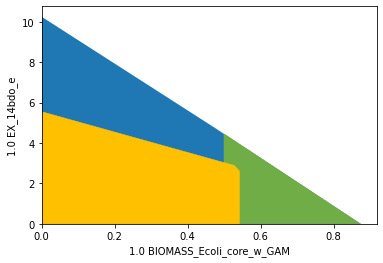

In [10]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.5',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The computed strain design generates a pGCP strain design with a relatively high maximal growth rate, however, at the cost of relatively many knockouts. The plot shows that OptKnock has exploited all means to improve maximal production at maximum growth. The maximum growth rate is only slightly above the demanded minimum. 

#### Example 10: OptKnock strain design with a tilted objective function

The last example showed that predicted strain designs not always *guarantee* product synthesis at maximum growth. A tilted objective function can be used to simulate that the cell not only maximizes growth but also minimizes product synthesis and thus opposes the engineering goal. Factoring in this secondary goal by the cell with a sufficiently small objective coefficient will lead to more agressive stain designs that counteract the cells possible minimization of production.

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 86 genes and 49 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (267 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 149 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 121 rea

One compressed solution with cost 13.0 found and expanded to 4 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-pgi', '-kgtP', '-gdhA', '-gltP', '-aceA', '-maeA', '-maeB', '-pta', '-eutD', '-pykF', '-pykA', '-sucC']


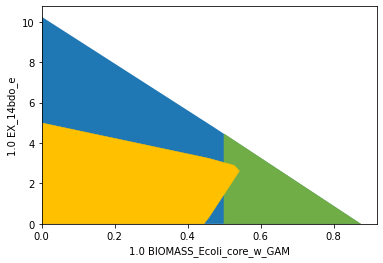

In [14]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.5',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

module_tilted_optknock = sd.SDModule(ecc_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM - 0.001 EX_14bdo_e',
                              outer_objective='EX_14bdo_e',
                              constraints='BIOMASS_Ecoli_core_w_GAM >= 0.5')

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_tilted_optknock,
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)

# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

As a result, we obtain an at least weakly growth coupled strain design.

#### Example 11: Genome-scale OptKnock strain design

Other than RobustKnock and OptCouple, OptKnock's computational effort is moderate so that the approach may be used in genome scale metabolic models. The first steps of model manipulation are identical to the ones in example 6.

In [1]:
import straindesign as sd
import cobra

cobra.Configuration().solver = 'cplex'
ijo = cobra.io.load_model('iJO1366')

# Create copy of model to which pathway will be added
ijo_14bdo = ijo.copy()
# If available, set the solver to cplex or gurobi. This will increase the chances
# of sucess enormously
ijo_14bdo.solver = 'cplex'

# Add metabolites to model
ijo_14bdo.add_metabolites([ cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
AKGDC      = cobra.Reaction('AKGDC')
SSCOARx    = cobra.Reaction('SSCOARx')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ijo_14bdo.add_reactions([SSCOARx,
                         AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
AKGDC.reaction      = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# define GPR rules for knock-inable genes
SSCOARx.gene_reaction_rule  = 'gsscoar'
AKGDC.gene_reaction_rule    = 'gakgdc'
ijo_14bdo.genes.gsscoar.name = 'sscoar'
ijo_14bdo.genes.gakgdc.name = 'akgdc'

exchange_reacs = [r for r in ijo_14bdo.reactions if all(s<0 for s in r.metabolites.values())]
# shut all exchange fluxes
for r in exchange_reacs:
    r.upper_bound = 0.0

# shut CO2 uptake
ijo_14bdo.reactions.EX_co2_e.lower_bound    = 0.0

# keep main fermentation products open
ijo_14bdo.reactions.EX_14bdo_e.upper_bound  = 1000.0
ijo_14bdo.reactions.EX_ac_e.upper_bound     = 1000.0
ijo_14bdo.reactions.EX_co2_e.upper_bound    = 1000.0
ijo_14bdo.reactions.EX_etoh_e.upper_bound   = 1000.0
ijo_14bdo.reactions.EX_for_e.upper_bound    = 1000.0
ijo_14bdo.reactions.EX_h2_e.upper_bound     = 1000.0
ijo_14bdo.reactions.EX_h2o2_e.upper_bound   = 1000.0
ijo_14bdo.reactions.EX_h2o_e.upper_bound    = 1000.0
ijo_14bdo.reactions.EX_h_e.upper_bound      = 1000.0
ijo_14bdo.reactions.EX_lac__D_e.upper_bound = 1000.0
ijo_14bdo.reactions.EX_meoh_e.upper_bound   = 1000.0
ijo_14bdo.reactions.EX_o2_e.upper_bound     = 1000.0
ijo_14bdo.reactions.EX_succ_e.upper_bound   = 1000.0
ijo_14bdo.reactions.EX_tungs_e.upper_bound  = 1000.0
ijo_14bdo.reactions.DM_4crsol_c.upper_bound = 1000.0
ijo_14bdo.reactions.DM_5drib_c.upper_bound  = 1000.0
ijo_14bdo.reactions.DM_aacald_c.upper_bound = 1000.0
ijo_14bdo.reactions.DM_amob_c.upper_bound   = 1000.0
ijo_14bdo.reactions.DM_mththf_c.upper_bound = 1000.0
ijo_14bdo.reactions.DM_oxam_c.upper_bound   = 1000.0

# substitute GPR rule in ATPS4rpp (all genes occur only in ATPS)
atps_genes = [g for g in ijo_14bdo.reactions.ATPS4rpp.genes]
ijo_14bdo.reactions.ATPS4rpp.gene_reaction_rule = str(atps_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,atps_genes[1:])
atps_genes[0].name = 'atpX'

# substitute GPR rules in NADH16pp, NADH17pp, NADH18pp (all genes occur only in NADHxxpp and GPR rules are identical)
nuo_genes = [g for g in ijo_14bdo.reactions.NADH16pp.genes]
ijo_14bdo.reactions.NADH16pp.gene_reaction_rule = str(nuo_genes[0])
ijo_14bdo.reactions.NADH17pp.gene_reaction_rule = str(nuo_genes[0])
ijo_14bdo.reactions.NADH18pp.gene_reaction_rule = str(nuo_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,nuo_genes[1:])
nuo_genes[0].name = 'nuoX'

# substitute GPR rules in FRD2, FRD3 (genes occur only in FRD2 and FRD3 and GPR rules are identical)
frd_genes = [g for g in ijo_14bdo.reactions.FRD2.genes]
ijo_14bdo.reactions.FRD2.gene_reaction_rule = str(frd_genes[0])
ijo_14bdo.reactions.FRD3.gene_reaction_rule = str(frd_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,frd_genes[1:])
frd_genes[0].name = 'frdX'

# substitute GPR rule in CYTBO3_4pp
cyo_genes = [g for g in ijo_14bdo.reactions.CYTBO3_4pp.genes]
ijo_14bdo.reactions.CYTBO3_4pp.gene_reaction_rule = str(cyo_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,cyo_genes[1:])
cyo_genes[0].name = 'cyoX'

# substitute GPR rule in THD2pp
pnt_genes = [g for g in ijo_14bdo.reactions.THD2pp.genes]
ijo_14bdo.reactions.THD2pp.gene_reaction_rule = str(pnt_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,pnt_genes[1:])
pnt_genes[0].name = 'pntX'

# substitute GPR rule in PDH and AKGDH
ace_genes = [g for g in ijo_14bdo.genes if g.name in ['aceE', 'aceF']]
sucAB_genes = [g for g in ijo_14bdo.genes if g.name in ['sucA', 'sucB']]
lpd = [g for g in ijo_14bdo.genes if g.name == 'lpd'][0]
ijo_14bdo.reactions.PDH.gene_reaction_rule = str(ace_genes[0])+' and '+str(lpd)
ijo_14bdo.reactions.AKGDH.gene_reaction_rule = str(sucAB_genes[0])+' and '+str(lpd)
cobra.manipulation.remove_genes(ijo_14bdo,ace_genes[1:])
cobra.manipulation.remove_genes(ijo_14bdo,sucAB_genes[1:])
ace_genes[0].name = 'aceEF'
sucAB_genes[0].name = 'sucAB'

# substitute GPR rule in SUCOAS
sucCD_genes = [g for g in ijo_14bdo.reactions.SUCOAS.genes]
ijo_14bdo.reactions.SUCOAS.gene_reaction_rule = str(sucCD_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,sucCD_genes[1:])
sucCD_genes[0].name = 'sucCD'

# substitute GPR rule in SUCDi
sdh_genes = [g for g in ijo_14bdo.reactions.SUCDi.genes]
ijo_14bdo.reactions.SUCDi.gene_reaction_rule = str(sdh_genes[0])
cobra.manipulation.remove_genes(ijo_14bdo,sdh_genes[1:])
sdh_genes[0].name = 'sdhX'

# Verify that pathway is operational
sol = sd.fba(ijo_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Maximum possible 1,4-BDO synthesis rate: 10.659770114940812.


Now that we introduced the 1,4-BDO pathway into the model and prepared it for strain design computation, we can continue with the problem formulation. We reduce the enforced attainable growth rate to relax the strain design problem. By introducing a minimum production threshold, we are able to still use the 'ANY' approach. This guarantees at least potentially growth-coupled production, although it is unlikely to identify the strategy with the highetst production potential this way. If the computation is successful, we can repeat the computation with the 'BEST' approach. If the computation is unsuccessful, one should consider using smaller models, such as iJO1366 or compute reaction instead of gene interventions.

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (2592 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 931 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (931 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 931 reactions, 420 metabolites
INFO:root:  810 targetable reactions
INFO

One compressed solution with cost 3.0 found and expanded to 2 solutions in the uncompressed netork.
Example intervention set: ['-AKGDH', '-ATPS4rpp', '-ACKr']


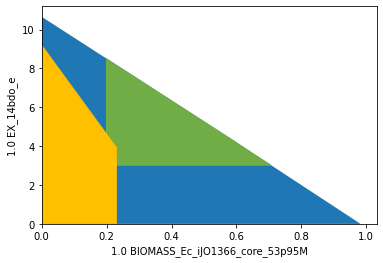

In [6]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ijo_14bdo,
                                               ('BIOMASS_Ec_iJO1366_core_53p95M ','EX_14bdo_e'), 
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ijo_14bdo,
                                               ('BIOMASS_Ec_iJO1366_core_53p95M ','EX_14bdo_e'),
                                               constraints=['BIOMASS_Ec_iJO1366_core_53p95M >=0.2',
                                                            'EX_14bdo_e >=3'],
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

module_tilted_optknock = sd.SDModule(ijo_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ec_iJO1366_core_53p95M ', #  - 0.001 EX_14bdo_e
                              outer_objective='EX_14bdo_e',
                              constraints=['BIOMASS_Ec_iJO1366_core_53p95M  >= 0.2','EX_14bdo_e >=3'])

# add AKGDC and SSCOARx as adition candidates
ki_cost = {'AKGDC': 1.0, 'SSCOARx':1}
# possible knockout of O2
ko_cost = {r.id : 1.0 for r in ijo_14bdo.reactions if r.genes and ijo_14bdo.genes.s0001 not in r.genes}
ko_cost.update({'EX_o2_e': 1.0})
# remove AKGDC and SSCOARx from knockout candidates
ko_cost.pop('AKGDC')
ko_cost.pop('SSCOARx')
# Compute strain designs
sols = sd.compute_strain_designs(ijo_14bdo,
                                 sd_modules = module_tilted_optknock,
                                 max_solutions = 1,
                                 max_cost = 3,
                                 ki_cost = ki_cost,
                                 ko_cost = ko_cost,
                                 solution_approach = sd.names.BEST)

# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.reaction_sd[0].items() if v!=0]}")

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ijo_14bdo,
                                               ('BIOMASS_Ec_iJO1366_core_53p95M ','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

## RobustKnock <a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref3'><sup>[3]</sup></a> 

The RobustKnock <a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref3'><sup>[3]</sup></a> approach usues multi-level optimization in a similar way to OptKnock. Whereas Optknock guarantees potentially growth-coupled production, RobusKnock guarantees at least weakly growth coupled production. This is achieved by introducing a third optimization layer. In order to avoid growth-maximal flux states with no production, RobustKnock *maximizes the production rate at maximum growth under the premise that is previously minimized*. The problem can be formalized as follows:
$$
\begin{array}{ll}
    \text{maximize} \; & v_{production} \\
    \text{subject to}  & \begin{array}{ll}
        \text{minimize} \; & v_{production} \\
        \text{subject to}  & \begin{array}{ll}
            \text{maximize} &  v_{biomass} \hspace{10em} \\
            \text{subject to} & \mathbf{S~v=0} \\
            & v_{BM} \ge v_{BM}^{min} \\
            & (1-z_i)\cdot lb_i \le v_i \le (1-z_i)\cdot ub_i, ~\forall i\in\{1,\dots,n\}\\
            &\sum z_i \le \text{maxKOs}\\
            &z_i \in \{0,1\}
\end{array}\end{array}\end{array}
$$

To translate the presented problem into a single-layer probem that can be used in a Mixed-Integer Linear Problem, one applies the duality principle twice, once on the original problem, and then once again to the linearized nested problem. This yields the MILP:

$$
\begin{gathered}
\text{maximize} \; v_{production} \\
\text{subject to} \\
\begin{array}{lllll}
    \begin{bmatrix}
        ~~\mathbf G & \mathbf 0 & \mathbf 0 & \mathbf 0 & \mathbf 0 \\
        ~~\mathbf D & \mathbf 0 & \mathbf 0 & \mathbf 0 & \mathbf 0 \\
        \mathbf{-c^\intercal_{prod,min}}~ & \mathbf{g^\intercal} & \mathbf 0 & \mathbf{c^\intercal_{BM}} & \mathbf 0\\
        ~~\mathbf 0 & \mathbf{G^\intercal} & \mathbf{-c^\intercal_{BM}} & \mathbf 0 &  \mathbf{I_{KO}} \\
        ~~\mathbf 0 & \mathbf 0 & \mathbf g & \mathbf G & \mathbf 0 \\
    \end{bmatrix} &
    \begin{bmatrix}
        \mathbf{v} \\ \mathbf{u} \\ \mathbf{t} \\ \mathbf{r} \\ \mathbf{s}
    \end{bmatrix} &
    \begin{matrix}
        \le \\ \le \\ = \\ = \\ \ge
    \end{matrix}
    \begin{bmatrix}\mathbf g \\ \mathbf d \\ 0 \\ \mathbf{c^\intercal_{BM}} \\ \mathbf 0 \end{bmatrix} \\
\end{array} \\
\forall i: z_i = 1 \rightarrow v_i = 0 \\
\forall i: z_i = 1 \rightarrow r_i = 0 \\
\forall i: z_i = 0 \rightarrow s_i = 0 \\
\sum z_i \le MaxNoKO \\
\mathbf{u\ge 0}, \hskip 1em z\in\{0,1\}
\end{gathered}
$$

#### Example 12: RobustKnock strain design

In StrainDesign, computing OptKnock strain designs is not any different from computing OptKnock strategies. One simply declares a RobustKnock instead of an Optknock module.

In [5]:
module_robustknock = sd.SDModule(ecc_14bdo,sd.names.ROBUSTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              outer_objective='EX_14bdo_e',
                              constraints='BIOMASS_Ecoli_core_w_GAM >= 0.5')

Launching the strain design computation:

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_robustknock,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 86 genes and 49 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (267 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 149 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 121 re

One compressed solution with cost 14.0 found and expanded to 4 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-pgi', '-kgtP', '-gdhA', '-gltP', '-aceA', '-maeA', '-maeB', '-purT', '-ackA', '-tdcD', '-pykF', '-pykA', '-sucC']


Plotting results:

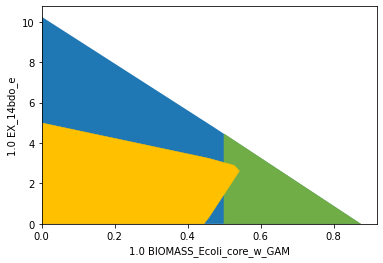

In [7]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
# Plot minimal enforced growth rate
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.5',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The RobustKnock problem is significantly larger than the OptKnock problem. Genome-scale strain design problems are often computationally too expensive to solve. To assess whether genome-scale computation is possible, one should first define a very relaxed problem, use reaction KOs and solve with the 'ANY' approach before attempting more complex setups.

## OptCouple

Optcouple <a href='#https://straindesign.readthedocs.io/en/latest/index.html#ref4'><sup>[4]</sup></a> pursues a slightly different approach from OptKnock and RobustKnock as it aims to maximize the "growth-coupling potential" (GCP), the span of growth rates ranging from (left) the maximum growth rate without product synthesis to (right) the global maximum growth rate (Figure below taken from the original publication). 

<img style="float:left; width:20%" src="../img/optcouple.jpg" />

Mathematically, the OptCouple appraoch has many parallels to other nested multi-level approaches. In particular OptCouple demands the solution of two distinct flux states. The first subproblem determines the globally maximum flux state. Herefore, LP-duality may be employed to construct a subproblem that is identical to an MCS PROTECT module with an implicit optimization of growth (and optionally a minimum threshold for productivity). The second flux state that needs to be referenced has maximum growth under the condition that there is no product synthesis. This is again similar to the MCS PROTECT module, however the constraint $v_{production}=0$ must be taken into account in the primal and its dual system. A weakness of OptCouple is that it does not return strain designs with substrate-uptake-coupled production, since a flux state with no production *must* exist as a lower reference point.

#### Example 13: OptCouple strain design

In StrainDesign, the computation of OptCouple designs is as straightforward as for the other approaches.

INFO:root:Preparing strain design computation.
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 127 genes and 63 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (335 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 182 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 154 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 146 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 145 re

One compressed solution with cost 7.0 found and expanded to 4 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-kgtP', '-maeB', '-rpe', '-sgcE', '-sucC', '-pntB']


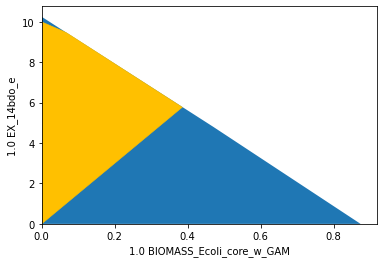

In [5]:
module_optcouple = sd.SDModule(ecc_14bdo,sd.names.OPTCOUPLE,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              prod_id='EX_14bdo_e',
                              min_gcp=0.3)

import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_optcouple,
                                 max_solutions = 1,
                                 max_cost = 15,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);

# OptKnock design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

As in this case, OptCouple computations often result in directionally growth-coupled strain designs, as the maximum growth coupling potential is often obtained when the maximal growth rate without production is zero. In our exampe, we observe a growth-coupling potential of 0.4.

## Combined nested-MCS combinations

Finally, nested strain design methods can also be combined with the MCS approach. Let's take a look at the following example: We would like to design a production strain for a 2-stage process. The first production stage is aerobic growth, the second stage in anaerobic production at growth rates between 0.05 and 0.1. 

We construct the strain design problems with an OptKnock and an MCS module as follows:

In [5]:
import logging
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

module_optknock = sd.SDModule(ecc_14bdo,sd.names.OPTKNOCK,
                              inner_objective='BIOMASS_Ecoli_core_w_GAM',
                              outer_objective='EX_14bdo_e',
                              constraints=['BIOMASS_Ecoli_core_w_GAM>=0.05','EX_o2_e = 0'])
module_mcs_suppress = sd.SDModule(ecc_14bdo,sd.names.SUPPRESS,
                              constraints=['BIOMASS_Ecoli_core_w_GAM>=0.1','EX_o2_e = 0'])
module_mcs_protect = sd.SDModule(ecc_14bdo,sd.names.PROTECT,
                              constraints=['BIOMASS_Ecoli_core_w_GAM>=0.4'])

## Compute strain designs
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_optknock,module_mcs_suppress,module_mcs_protect],
                                 max_solutions = 1,
                                 max_cost = 15,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);

# Aerobic design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot2.set_facecolor('#00C0FF')
plot2.set_edgecolor('#00C0FF')
# Anaerobic design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot3.set_facecolor('#FFC000')
plot3.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 79 genes and 45 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (253 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 140 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 117 reactions.
INFO:root:  Compression 4: Lumping parallel reactions.
INFO:root:  Reduced to 116 re

IndexError: list index out of range